<a href="https://colab.research.google.com/github/lucasprovenzano/HandsOnMachineLearning/blob/main/Chapter3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Fetching MNIST dataset from sklearn.
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

<function matplotlib.pyplot.show>

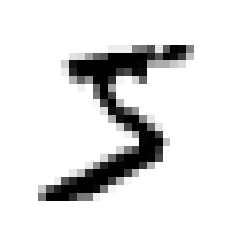

In [2]:
# Plotting a digit. 
import matplotlib as mpl
import matplotlib.pyplot as plt

X, y = mnist["data"], mnist["target"]

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show

In [3]:
# Checking the label 
y[0]

'5'

In [4]:
# Casting string labels to integers. 
import numpy as np

y = y.astype(np.uint8)

In [5]:
# Spliting in training and test set. 
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
# Training a binary classifier.
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [7]:
# Testint in the first digit. 
sgd_clf.predict([some_digit])

array([ True])

In [8]:
# implementing cross-validation.
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle= True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [9]:
# Using SKL cross_val function. 
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [10]:
# Non-5 classification. 
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)

In [11]:
# Measuring model accuracy
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [12]:
# Confusion Matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [13]:
# Pretending reach perfection. 
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [14]:
# Precision, Recall and F1 score. 
from sklearn.metrics import precision_score, recall_score, f1_score

pscore = precision_score(y_train_5, y_train_pred)
print(pscore)
rscore = recall_score(y_train_5,y_train_pred)
print(rscore)
f1score = f1_score(y_train_5, y_train_pred)
print(f1score)

0.8370879772350012
0.6511713705958311
0.7325171197343846


In [15]:
# Testing decision_function to see the clasifier score. 
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


In [16]:
# Choosing the right threshold
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

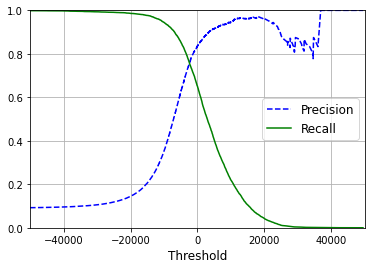

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.legend(loc="center right", fontsize=12) 
  plt.xlabel("Threshold", fontsize=12)        
  plt.grid(True)                              
  plt.axis([-50000, 50000, 0, 1])             

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [18]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


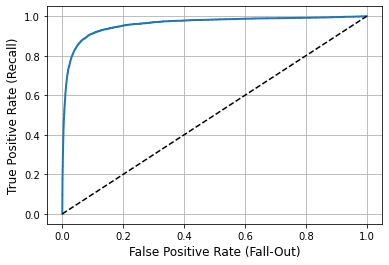

In [23]:
# ROC curve. 
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
  plt.plot(fpr, tpr, linewidth=2,label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False Positive Rate (Fall-Out)', fontsize=12) 
  plt.ylabel('True Positive Rate (Recall)', fontsize=12)    
  plt.grid(True)         

plot_roc_curve(fpr, tpr)
plt.show()